In [1]:
# Download spacy tokenization package
!spacy download en_core_web_sm

2024-06-28 22:27:56.286854: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-28 22:27:56.286908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-28 22:27:56.288235: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-28 22:27:56.294534: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-28 22:27:57.076380: W tensorflow/compiler/tf2

# Imports

In [17]:

# Used for model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Used to format data
import torchvision
import torchvision.transforms as transforms
# Used to show results
import matplotlib.pyplot as plt
# Used for data processes
import os
# Used for model handling
import copy
# Used to show results
import matplotlib.pyplot as plt
# Additional file imports
from dataset import Flickr8kDataset
from dataset import Collate
from model2 import EncoderDecoder

# Useful methods for later

In [22]:
# Displays an image with its respective caption
def displayImage(img, caption):
    
    # Unnormalize Image
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    # show captioned image
    plt.figure()
    plt.imshow(img.permute(1,2,0).cpu().numpy())
    plt.title(caption)
    plt.axis("off")
    # pause a bit so that plots are updated
    plt.pause(0.001)

In [4]:
def saveModel(model, args, name):
    # Directory Name
    directory = './models/'
    # Create models folder and checks if it exists
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory {directory} created successfully...")
    # Define path and name
    path = os.path.join(directory, name + '.pth')
    
    state = {
        'state_dict': model.state_dict(),
        'args': args
    }
    
    # Save model's parameters
    torch.save(state, f = path)

# Dataset / Data Handling

In [5]:
# Data transformations
transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [6]:
# Dataset path name
dataset_path = "./dataset/"
# DataLoader parameters
BATCH_SIZE = 256
num_workers = 8
# Initialize Dataset
root = os.path.join(dataset_path, 'Images')
annotations = os.path.join(dataset_path, 'captions.txt')
freq_threshold = 3
dataset = Flickr8kDataset(root, annotations, transform, freq_threshold)
# train/valid split
ratio = 0.8
train_split = int(ratio * len(dataset))
valid_split = len(dataset) - train_split
# splits dataset into train and valid
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_split, valid_split])

# Get numerical index of padding
pad_idx = dataset.vocab.stoi["<PAD>"]
# Pad dataset and initialize dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    num_workers = num_workers,
    shuffle = True,
    collate_fn=Collate(pad_idx)
    )
valid_loader = DataLoader(
    valid_dataset,
    batch_size = BATCH_SIZE,
    num_workers = num_workers,
    shuffle = True,
    pin_memory = True,
    collate_fn=Collate(pad_idx)
)

# Training and Validation Methods

In [18]:
def train_loop(model, train_loader, optimizer, criterion, device):
    # training loop
    model.train()
    avg_loss = 0
    for i, (image, captions) in enumerate(train_loader):
        # getting data
        image,captions = image.to(device),captions.permute(1,0).to(device)
        # Zero the gradients.
        optimizer.zero_grad()
        # Feed forward
        outputs= model(image, captions)
        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        avg_loss += loss.item()
        # Backward pass.
        loss.backward()
        # Update the parameters in the optimizer.
        optimizer.step()
    avg_loss /= len(train_loader)
    return avg_loss

In [19]:
def valid_loop(model, valid_loader, criterion, vocab, device):
    # validation loop
    model.eval()
    avg_loss = 0
    for i, (image, captions) in enumerate(valid_loader):
        # getting data
        image,captions = image.to(device),captions.permute(1,0).to(device)
        # Feed forward
        outputs= model(image, captions)
        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        avg_loss += loss.item()
    avg_loss /= len(valid_loader)
    
    with torch.inference_mode():
        caption = model.caption_image(image[0].unsqueeze(0), vocab)
        displayImage(image[0],caption)
    return avg_loss

# Model Initalization

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Hyperparameters
embed_size = 300
decoder_dim = 512
attention_dim = 256
vocab_size = len(dataset.vocab)
p = 0.5
lr = 0.0005

model_args = {
    "embed_size" : embed_size,
    "decoder_dim" : decoder_dim,
    "attention_dim" : attention_dim,
    "vocab_size" : len(dataset.vocab),
    "p" : p,
}

In [24]:
model = EncoderDecoder(
    embed_size,
    decoder_dim,
    attention_dim,
    vocab_size,
    p,
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.70)

EPOCHS = 25

# Training

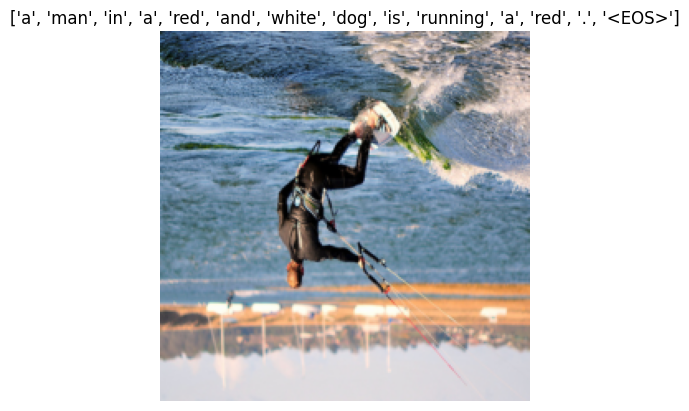

Epoch 0 | Train Loss: 4.7494963097760055 | Validation Loss: 3.9902257919311523


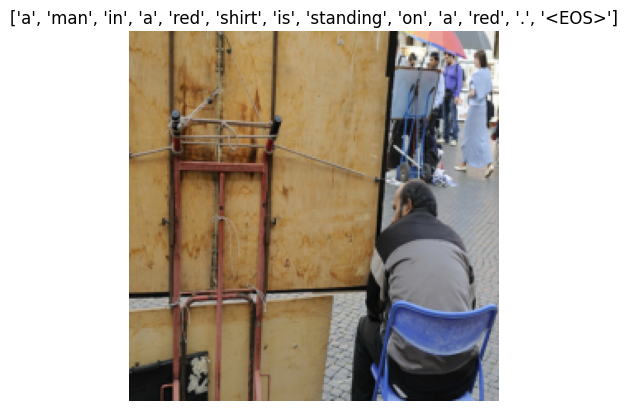

Epoch 1 | Train Loss: 3.863954878228856 | Validation Loss: 3.5829010233283043


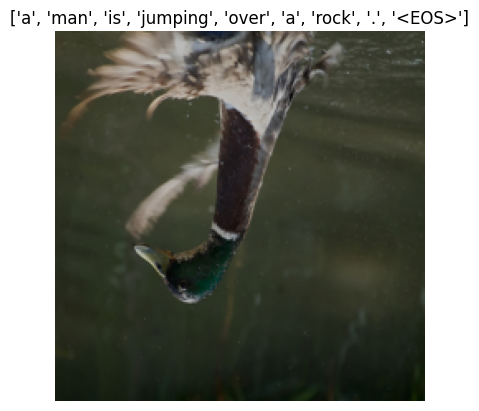

Epoch 2 | Train Loss: 3.582733366433091 | Validation Loss: 3.3827093467116356


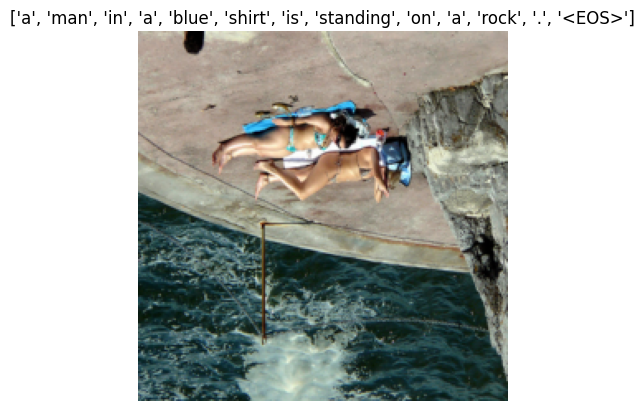

Epoch 3 | Train Loss: 3.4123247890021857 | Validation Loss: 3.247906744480133


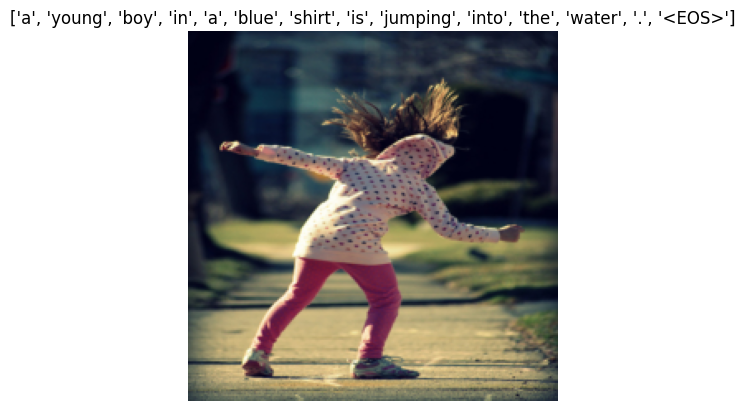

Epoch 4 | Train Loss: 3.287593588115662 | Validation Loss: 3.1471566036343575


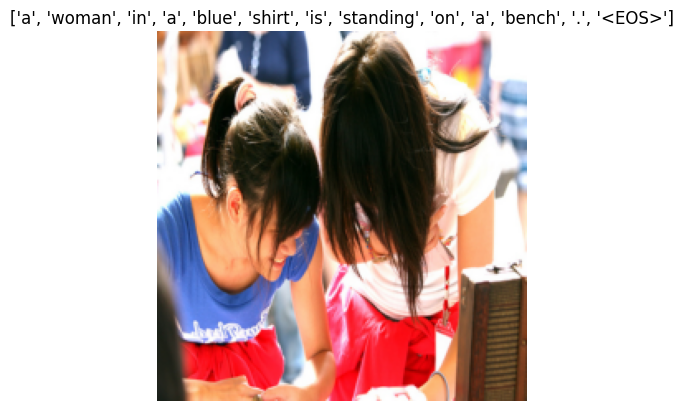

Epoch 5 | Train Loss: 3.192323551403256 | Validation Loss: 3.0730053931474686


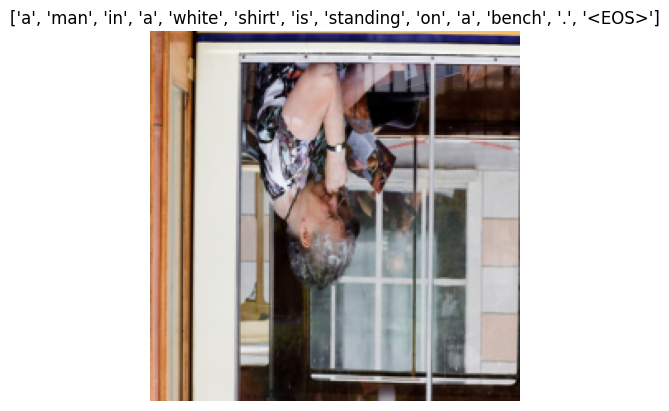

Epoch 6 | Train Loss: 3.1175251495181104 | Validation Loss: 3.014800876379013


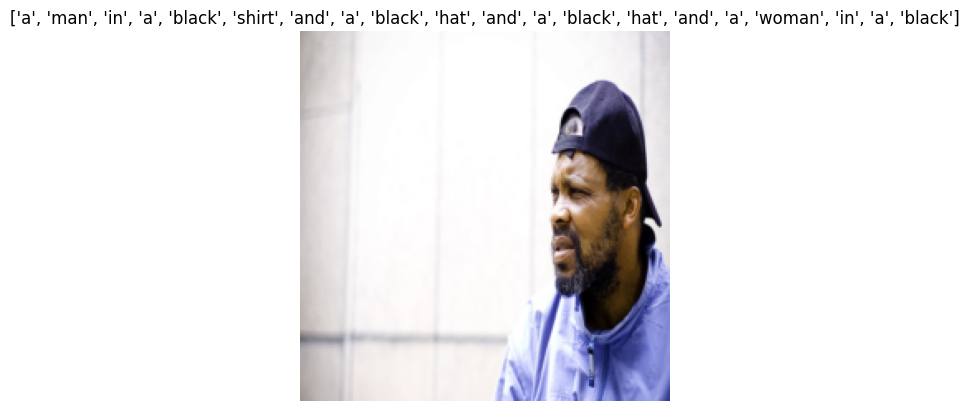

Epoch 7 | Train Loss: 3.054198576709417 | Validation Loss: 2.9606980308890343


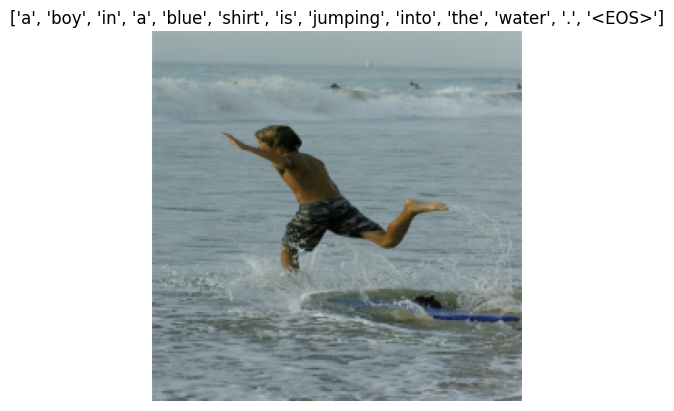

Epoch 8 | Train Loss: 2.997364209392878 | Validation Loss: 2.9250450134277344


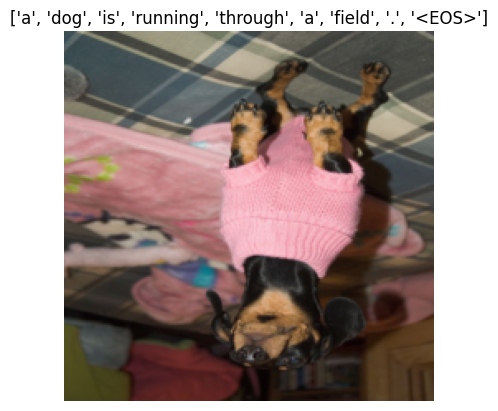

Epoch 9 | Train Loss: 2.9517291117840863 | Validation Loss: 2.8856213986873627


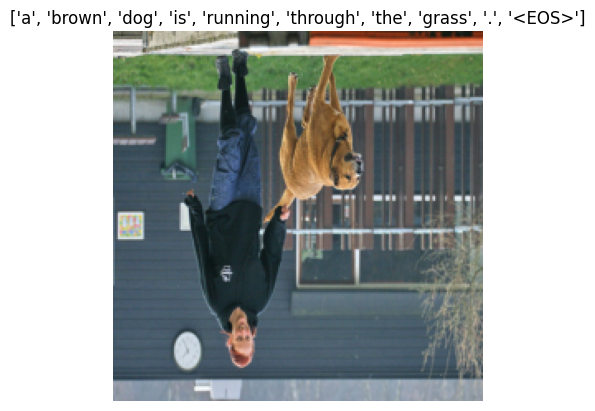

Epoch 10 | Train Loss: 2.906608483922763 | Validation Loss: 2.8566494435071945


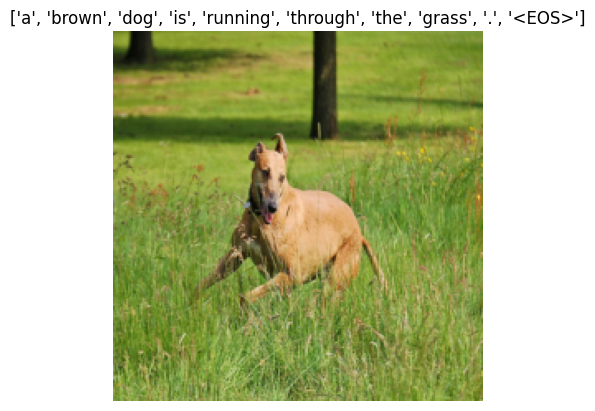

Epoch 11 | Train Loss: 2.8665509937316416 | Validation Loss: 2.82933958619833


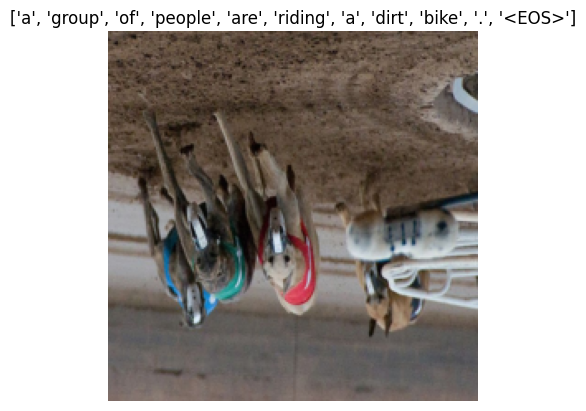

Epoch 12 | Train Loss: 2.831667702967726 | Validation Loss: 2.80649895966053


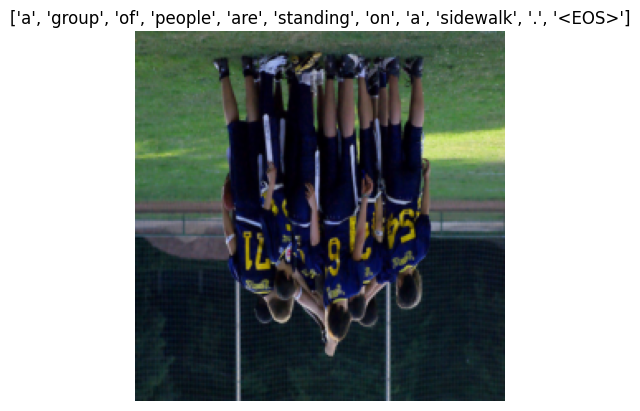

Epoch 13 | Train Loss: 2.797407116476945 | Validation Loss: 2.783336915075779


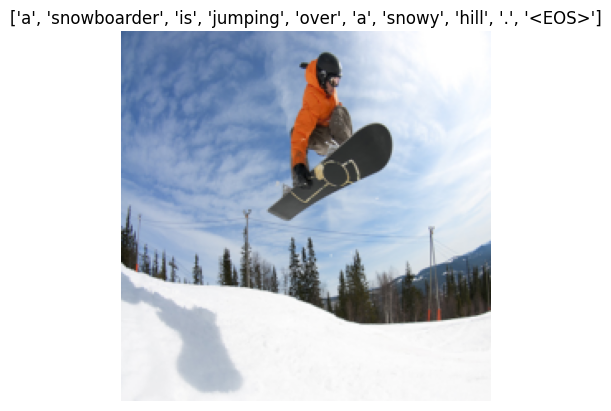

Epoch 14 | Train Loss: 2.764509411308709 | Validation Loss: 2.7635757476091385


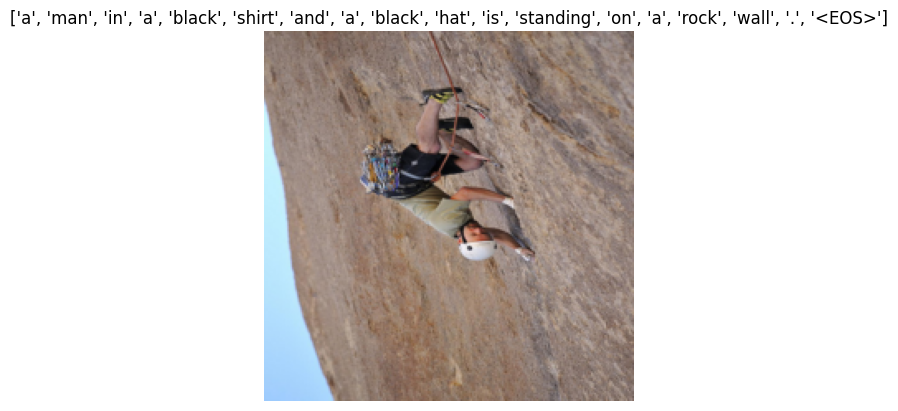

Epoch 15 | Train Loss: 2.7386550321353704 | Validation Loss: 2.7472949847579002


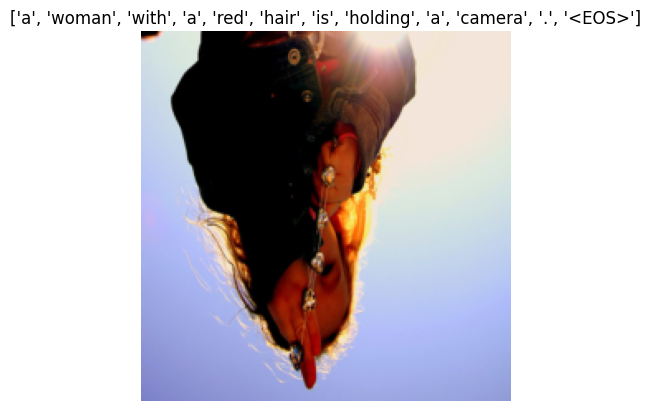

Epoch 16 | Train Loss: 2.7098578524401806 | Validation Loss: 2.7339753434062004


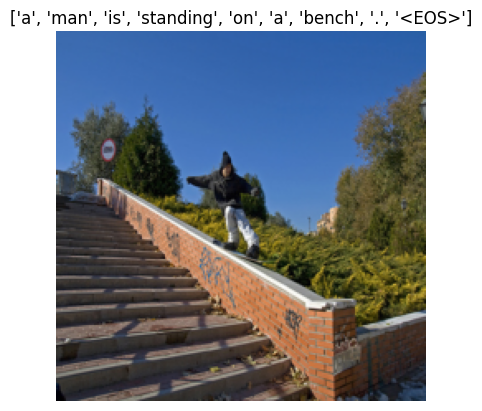

Epoch 17 | Train Loss: 2.6844438887017916 | Validation Loss: 2.7129200622439384


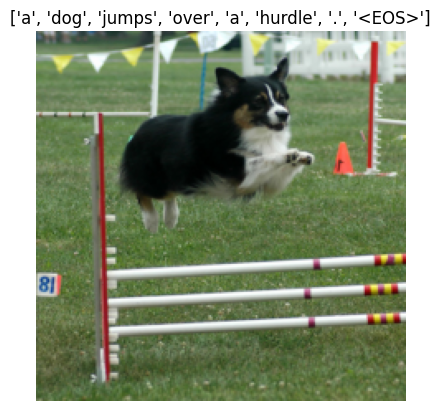

Epoch 18 | Train Loss: 2.6614048593626247 | Validation Loss: 2.6998791247606277


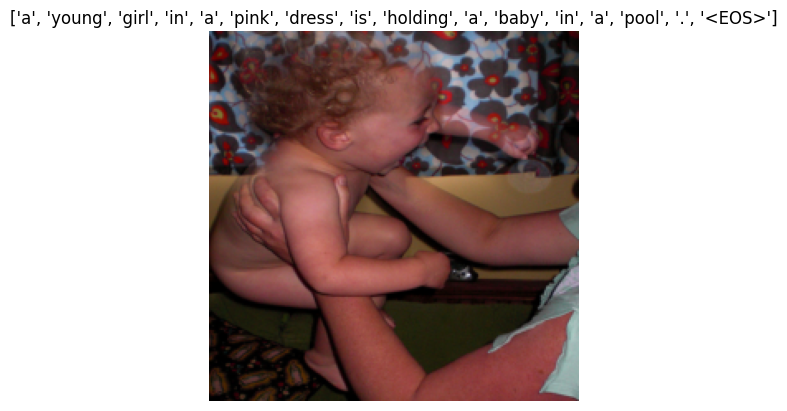

Epoch 19 | Train Loss: 2.6367091400416816 | Validation Loss: 2.690318815410137


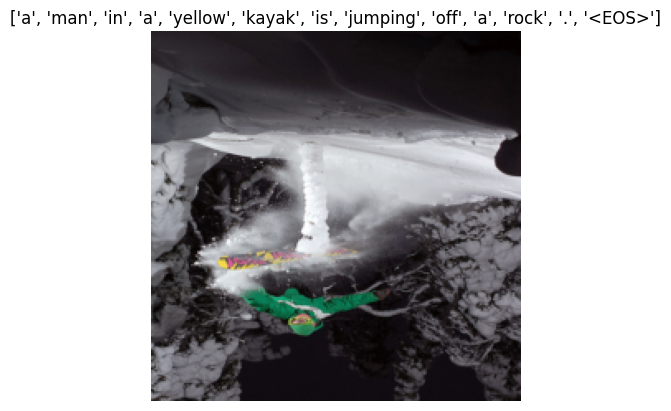

Epoch 20 | Train Loss: 2.612860613920557 | Validation Loss: 2.67775047570467


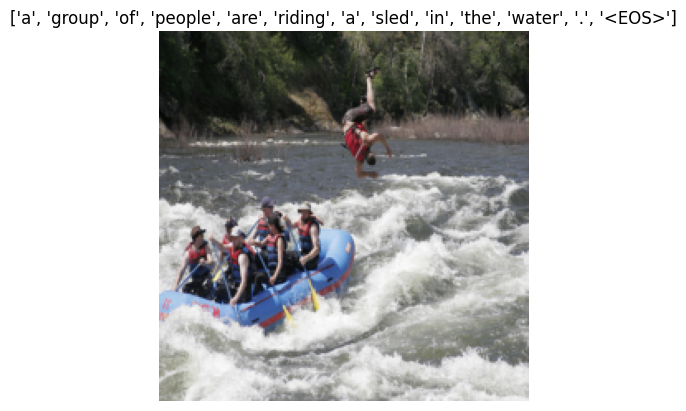

Epoch 21 | Train Loss: 2.5938227552128588 | Validation Loss: 2.6693457067012787


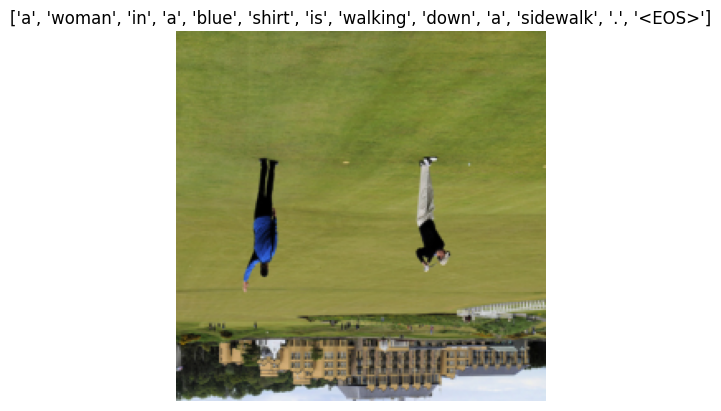

Epoch 22 | Train Loss: 2.5712187778292677 | Validation Loss: 2.6566237062215805


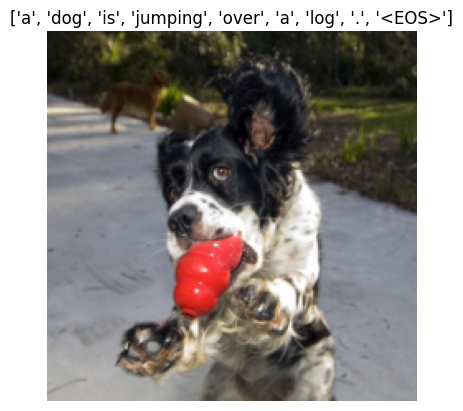

Epoch 23 | Train Loss: 2.5527165686990334 | Validation Loss: 2.649819739162922


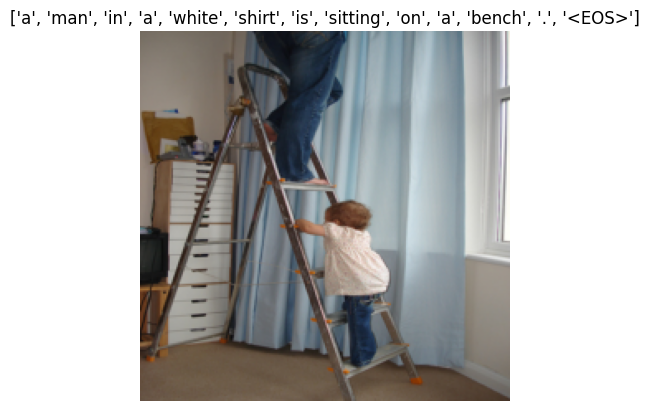

Epoch 24 | Train Loss: 2.5315666686831495 | Validation Loss: 2.6418415158987045


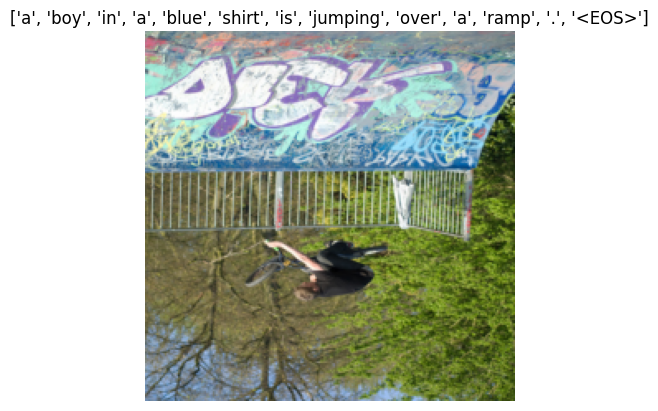

Epoch 25 | Train Loss: 2.5149163373811976 | Validation Loss: 2.6268598958849907


In [25]:
train_loss_i = []
validation_loss_i = []

vocab = dataset.vocab

best_loss = float('inf')

# Epoch loop
for epoch in range(EPOCHS+1):
    # train loop
    train_loss = train_loop(model, train_loader, optimizer, criterion, device)
    # evaluate loop
    valid_loss = valid_loop(copy.deepcopy(model), valid_loader, criterion, vocab, device)
    # learning rate adjuster
    if(valid_loss < best_loss):
        best_loss = valid_loss
    else:
        lr_scheduler.step()
    #append data to list    
    train_loss_i.append(train_loss)
    validation_loss_i.append(valid_loss)
    # print stats
    print("Epoch {} | Train Loss: {} | Validation Loss: {}".format(epoch, train_loss, valid_loss))

# save model
saveModel(model,model_args,'NewModel6')

Text(0.5, 1.0, 'Train vs Validation Loss')

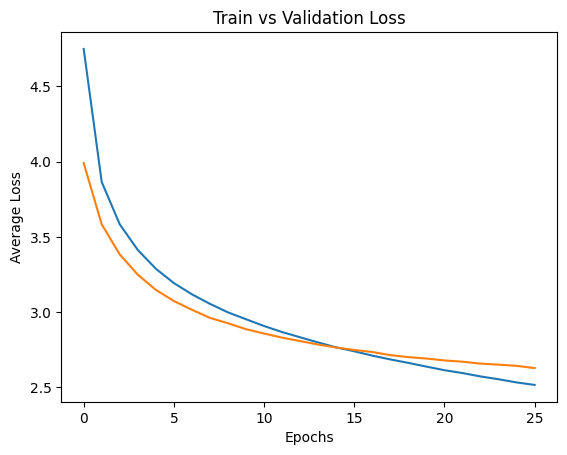

In [26]:
plt.figure
plt.plot(train_loss_i, label = "Training Loss")
plt.plot(validation_loss_i, label = "Validation Loss") 
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.title("Train vs Validation Loss")